# Stacking of models into two layers
1. First layer: train models on the whole training set
2. Second layer: train a model on the first layer's predictions and the rest of the training set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from src.data.data_fetcher import get_all_features, get_raw_data
from src.features.feature_engineering import prepare_data
from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data, fetch_preprocessed_uniform_data
pd.set_option('display.max_columns', 200)
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Get the data

In [2]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()

X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
X_test_estimated_a_processed, X_test_estimated_b_processed, X_test_estimated_c_processed = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)

x_whole.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,precip_5min:mm,precip_type_5min:idx,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,cloud_ratio,cloud_cover_over_30%,sun_addition,wind_times_temp,is_freezing,is_snow,is_rain
0,4.675,1.23925,0.000000e+00,0.000000,2067.925049,0.0,272.924988,0.000000,0.000000,0.000000,0.000000,91.949997,0.0,1.0,0.0,0.0,981.574951,0.0,0.0,65.949997,252.160492,0.0,279.774994,98.974998,45661.750000,3.800,1.100,3.625,0.0,1,0,0,-0.638384,0.769718,-0.866025,-0.500000,0.000000,0.000000,0.000000,0.929022,1,0.000000,1063.145020,0,0,0
1,4.400,1.23625,6.981340e+04,20.875000,1698.875000,0.0,271.975006,19.175001,60237.699219,2.250000,6097.700195,73.699997,1.0,0.0,0.0,0.0,976.950012,0.0,0.0,70.324997,168.481506,0.0,278.000000,93.649994,54169.699219,3.850,-3.775,0.600,0.0,0,1,0,-0.308812,0.951123,0.500000,-0.866025,43.143753,0.048057,0.087343,0.786973,1,21.425001,1070.299927,0,0,0
2,11.350,1.21775,1.767598e+05,58.775002,124.950005,0.0,286.299988,32.450001,106322.000000,1.000000,3798.399902,86.474998,1.0,0.0,0.0,0.0,1005.925049,0.0,0.0,90.275002,69.381248,0.0,287.549988,99.900002,33840.726562,1.825,1.600,0.825,0.0,0,1,0,-0.653160,-0.757220,0.866025,0.500000,32.450001,0.108581,0.021489,0.865616,1,33.450001,524.778687,0,0,0
3,4.150,1.30050,0.000000e+00,0.000000,5375.950195,0.0,271.125000,0.000000,0.000000,0.000000,0.000000,64.849998,0.0,1.0,0.0,0.0,1012.450012,0.0,0.0,78.275002,15.757500,0.0,273.549988,95.625000,28736.724609,1.950,-0.550,1.850,0.0,1,0,0,0.855075,-0.518505,0.000000,1.000000,0.000000,0.000000,0.000000,0.678170,1,0.000000,533.422485,0,0,0
4,4.300,1.25400,1.315013e+06,378.500000,1466.699951,0.0,271.675018,87.324997,305103.093750,278.799988,965443.125000,24.150000,1.0,0.0,0.0,0.0,1003.000000,0.0,0.0,52.099998,130.110260,0.0,278.500000,48.250000,42909.300781,1.000,-0.775,0.675,0.0,0,1,0,0.999930,-0.011826,0.866025,-0.500000,24346.208984,0.394620,0.734170,0.500518,0,366.125000,278.500000,0,0,0


## Train test split for the base layer and meta layer

In [6]:
# The base layer gets 80% of the data
# The meta layer gets 20% of the data
base_to_meta_layer_split = 0.8

base_x_train = x_whole.sample(frac=base_to_meta_layer_split)
meta_x_train = x_whole.sample(frac=1-base_to_meta_layer_split)

# Get the corresponding y values
base_y_train = y_whole[base_x_train.index]
meta_y_train = y_whole[meta_x_train.index]
base_x_train.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m',
       'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W',
       'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'is_day:idx', 'is_in_shadow:idx',
       'precip_5min:mm', 'precip_type_5min:idx', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sun_azimuth:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
       'location_a', 'location_b', 'location_c', 'sin_day_of_year',
       'cos_day_of_year', 'sin_hour', 'cos_hour', 'sun_product',
       'modified_solar_elevation', 'effective_radiation', 'cloud_ratio',
       'cloud_cover_over_30%', 'sun_addition', 'wind_times_temp',
       'is_freezing', 'is_snow', 'is_rain'],
  

# Train Base level models
It is important to use a variety of models to get a diverse set of predictions.

I want a model to check if there is a linear relationship between the location features and the target. I will use a linear regression model for this.
I want to check if the different irradiation values are correlated with the target. I will use xgboost for this.
I want to check if the different temperature values are correlated with the target. I will use 


## Solar irradiance model

In [4]:
# K-fold cross validation

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

total_mae = 0

reg_models = []

solar_features = ['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'sun_azimuth:d', 'effective_radiation', 'sun_product', 'sun_addition']
location_features = ['location_a', 'location_b', 'location_c']
time_features = ['sin_day_of_year', 'cos_day_of_year', 'sin_hour', 'cos_hour']
solar_irradiance = base_x_train[['sun_product', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m','diffuse_rad:W','diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'sin_hour']]
for train_index, test_index in kf.split(solar_irradiance):

    reg = xgb.XGBRegressor(n_estimators=100000,
                       early_stopping_rounds=50,
                       learning_rate= 0.01,
                       objective="reg:linear",
                       eval_metric="mae",
                       sub_sample = 0.9,
                       colsample_bytree = 0.8,
                       gamma = 0,
                       alpha = 0.001,
                       min_child_weight=0,
                       max_depth=9)

    X_train, X_test = x_whole.iloc[train_index], x_whole.iloc[test_index]
    y_train, y_test = y_whole.iloc[train_index], y_whole.iloc[test_index]

    reg.fit(X_train, y_train,
            eval_set=[(X_val_est_combined, y_val_est_combined)],
            verbose=100)
    
    reg_models.append(reg)
    predictions = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    total_mae += mae
    
    print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

average_mse = total_mae / num_folds
print(f"Average Mean Squared Error: {average_mse}")


[00:58:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:58:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.

[0]	validation_0-mae:180.56190
[100]	validation_0-mae:92.03995
[200]	validation_0-mae:76.20094
[300]	validation_0-mae:71.21334
[400]	validation_0-mae:69.15036
[500]	validation_0-mae:68.35878
[554]	validation_0-mae:68.40819
Fold 87.47447246339597, Mean Absolute Error: 87.47447246339597
[00:59:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:59:32] WARNING: C:\buildkite-agent\builds\buildk

In [5]:
x_whole["solar_irradiance"] = time_regression.predict(x_whole[['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m','diffuse_rad:W','diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J']])
x_whole["solar_irradiance"].describe()
# Add to the evaluation set
X_val_obs_combined["solar_irradiance"] = time_regression.predict(X_val_obs_combined[['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m','diffuse_rad:W','diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J']])
X_val_est_combined["solar_irradiance"] = time_regression.predict(X_val_est_combined[['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m','diffuse_rad:W','diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J']])
X_test_estimated_a_processed["solar_irradiance"] = time_regression.predict(X_test_estimated_a_processed[['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m','diffuse_rad:W','diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J']])
X_test_estimated_b_processed["solar_irradiance"] = time_regression.predict(X_test_estimated_b_processed[['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m','diffuse_rad:W','diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J']])
X_test_estimated_c_processed["solar_irradiance"] = time_regression.predict(X_test_estimated_c_processed[['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m','diffuse_rad:W','diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J']])



NameError: name 'time_regression' is not defined

## Time based features model

In [ ]:
# 'sin_day_of_year', 'cos_day_of_year', 'sin_hour', 'cos_hour' help capture the cyclical nature of solar power generation within a day and across seasons.
time_regression = RandomForestRegressor(n_estimators=100, random_state=42)

time_regression.fit(X_train_obs_combined[['sin_day_of_year', 'cos_day_of_year', 'sin_hour', 'cos_hour']], y_train_obs_combined)

RandomForestRegressor(random_state=42)

In [ ]:
x_whole["season_and_time_impact"] = time_regression.predict(x_whole[["sin_day_of_year", "cos_day_of_year", "sin_hour", "cos_hour"]])
x_whole["season_and_time_impact"].describe()
# Add to eval set
X_val_obs_combined["season_and_time_impact"] = time_regression.predict(X_val_obs_combined[["sin_day_of_year", "cos_day_of_year", "sin_hour", "cos_hour"]])
X_val_est_combined["season_and_time_impact"] = time_regression.predict(X_val_est_combined[["sin_day_of_year", "cos_day_of_year", "sin_hour", "cos_hour"]])
X_test_estimated_a_processed["season_and_time_impact"] = time_regression.predict(X_test_estimated_a_processed[["sin_day_of_year", "cos_day_of_year", "sin_hour", "cos_hour"]])
X_test_estimated_b_processed["season_and_time_impact"] = time_regression.predict(X_test_estimated_b_processed[["sin_day_of_year", "cos_day_of_year", "sin_hour", "cos_hour"]])
X_test_estimated_c_processed["season_and_time_impact"] = time_regression.predict(X_test_estimated_c_processed[["sin_day_of_year", "cos_day_of_year", "sin_hour", "cos_hour"]])


In [ ]:
x_whole.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,precip_5min:mm,precip_type_5min:idx,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,cloud_ratio,cloud_cover_over_30%,sun_addition,wind_times_temp,is_freezing,is_snow,is_rain,solar_irradiance,season_and_time_impact
count,77049.000000,77049.000000,7.704900e+04,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,7.704900e+04,77049.000000,7.704900e+04,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,7.704900e+04,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000,77049.000000
mean,6.241155,1.252290,5.347363e+05,148.523712,1639.391602,0.007885,275.821411,39.971447,1.440655e+05,52.255939,1.880855e+05,66.943855,0.482235,0.565465,0.005829,0.084216,1001.690125,0.744724,0.010283,73.924072,179.713455,0.059238,279.985229,73.754227,32998.621094,3.012391,0.712764,0.666081,0.000034,0.384846,0.326078,0.289076,-0.011323,0.027732,-0.004999,1.623435e-02,6231.525391,0.155903,0.155956,0.863937,0.805176,92.227379,842.274231,0.124440,0.102960,0.099015,329.980040,318.677729
std,2.728858,0.036446,8.452756e+05,234.831375,1794.910645,0.237462,6.770890,61.646030,2.200077e+05,116.094185,4.136755e+05,34.011597,0.485604,0.483357,0.030000,0.322168,12.852139,5.278136,0.042882,14.194100,98.450890,0.107865,6.549295,33.702248,17984.371094,1.743020,2.751949,1.884110,0.006123,0.486562,0.468779,0.453336,0.708129,0.705456,0.709315,7.046966e-01,14841.673828,0.225098,0.261879,0.230529,0.396068,159.886719,485.585266,0.330085,0.303909,0.298684,661.997608,550.192826
min,0.500000,1.139250,0.000000e+00,0.000000,0.000000,-1.000000,247.425003,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,935.750000,0.000000,0.000000,19.575001,6.983000,0.000000,258.024994,0.000000,132.375000,0.025000,-7.225000,-8.400000,-0.100000,0.000000,0.000000,0.000000,-0.999999,-0.999979,-1.000000,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.013125,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.200000,1.227500,0.000000e+00,0.000000,512.700012,0.000000,271.299988,0.000000,0.000000e+00,0.000000,0.000000e+00,42.150002,0.000000,0.000000,0.000000,0.000000,993.900024,0.000000,0.000000,64.599998,93.375000,0.000000,275.399994,53.700001,16442.099609,1.675000,-1.300000,-0.600000,0.000000,0.000000,0.000000,0.000000,-0.726225,-0.673275,-0.707107,-7.071068e-01,0.000000,0.000000,0.000000,0.809961,1.000000,0.000000,465.482513,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.700000,1.251000,5.598700e+03,1.550000,1109.125000,0.000000,275.725006,0.850000,8.360600e+03,0.000000,0.000000e+00,79.375000,0.250000,1.000000,0.000000,0.000000,1002.700012,0.000000,0.000000,76.349998,180.094498,0.000000,279.375000,92.599998,37146.273438,2.675000,0.350000,0.700000,0.000000,0.000000,0.000000,0.000000,-0.004301,0.052658,0.000000,6.123234e-17,0.000000,0.000000,0.000000,0.991500,1.000000,0.875000,748.094971,0.000000,0.000000,0.000000,1.024675,1.875825
75%,8.075001,1.275250,8.419113e+05,234.375000,2000.949951,0.000000,281.000000,66.425003,2.398408e+05,31.549999,1.193710e+05,98.324997,1.000000,1.000000,0.000000,0.000000,1010.650024,0.000

# Train meta learner model

In [ ]:
# K-fold cross validation

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

total_mae = 0

reg_models = []


for train_index, test_index in kf.split(x_whole):

    reg = xgb.XGBRegressor(n_estimators=100000,
                       early_stopping_rounds=50,
                       learning_rate= 0.01,
                       objective="reg:linear",
                       eval_metric="mae",
                       sub_sample = 0.9,
                       colsample_bytree = 0.8,
                       gamma = 0,
                       alpha = 0.001,
                       min_child_weight=0,
                       max_depth=9)

    X_train, X_test = x_whole.iloc[train_index], x_whole.iloc[test_index]
    y_train, y_test = y_whole.iloc[train_index], y_whole.iloc[test_index]

    reg.fit(X_train, y_train,
            eval_set=[(X_val_est_combined, y_val_est_combined)],
            verbose=100)
    
    reg_models.append(reg)
    predictions = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    total_mae += mae
    
    print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

average_mse = total_mae / num_folds
print(f"Average Mean Squared Error: {average_mse}")

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:date_calc: datetime64[ns]

<Figure size 10000x10000 with 0 Axes>

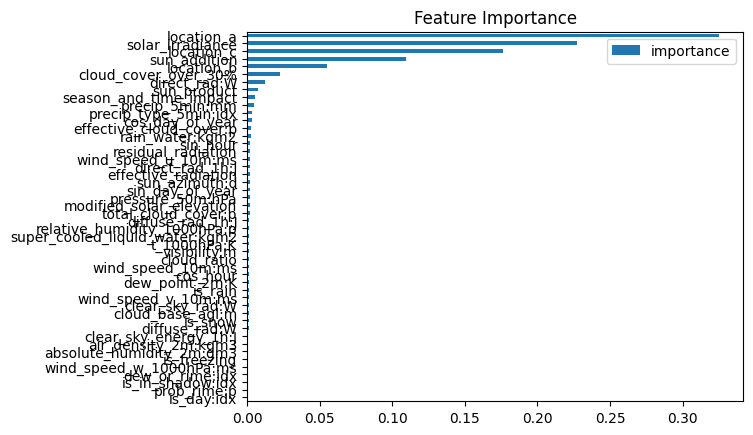

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

plt.figure(figsize=(100,100))
plt.tight_layout()
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

In [ ]:
def multi_predict(x_values :pd.DataFrame, models) -> pd.DataFrame:
    """
    Function for predicting on multiple models and averaging the results
    """
    results = models[0].predict(x_values)
    for model in models[1:]:
        model: xgb.XGBRegressor
        prediction = model.predict(x_values)
        results += prediction
    
    results = results / len(models)

    return results


In [ ]:
y_pred_val_obs_combined = multi_predict(X_val_obs_combined, reg_models)
y_pred_val_est_combined = multi_predict(X_val_est_combined, reg_models)

# Evaluate the model's performance using Mean Absolute Error (MAE) on the combined validation observed data
mae_obs_combined = mean_absolute_error(y_val_obs_combined, y_pred_val_obs_combined)
mae_est_combined = mean_absolute_error(y_val_est_combined, y_pred_val_est_combined)
print('MAE on validation observed data: ', mae_obs_combined)
print('MAE on validation estimated data: ', mae_est_combined)


MAE on validation observed data:  63.37159759660435
MAE on validation estimated data:  79.57505515401992


In [ ]:
# Predict on the cleaned validation set
from src.features.preprocess_data import get_final_prediction

y_val_pred_est_a = multi_predict(X_test_estimated_a_processed, reg_models)
y_val_pred_est_b = multi_predict(X_test_estimated_b_processed, reg_models)
y_val_pred_est_c = multi_predict(X_test_estimated_c_processed, reg_models)

# Combine the predictions into a single array
y_pred_test_est_combined = get_final_prediction(y_val_pred_est_a, y_val_pred_est_b, y_val_pred_est_c)
y_pred_test_est_combined.shape

# Make all negative predictions 0
y_pred_test_est_combined["prediction"][y_pred_test_est_combined["prediction"] < 0] = 0

y_pred_test_est_combined.describe()

,id,prediction
count,2160.000000,2160.000000
mean,1079.500000,537.001099
std,623.682612,833.408936
min,0.000000,0.000000
25%,539.750000,9.487578
50%,1079.500000,236.322464
75%,1619.250000,653.135422
max,2159.000000,5127.107910


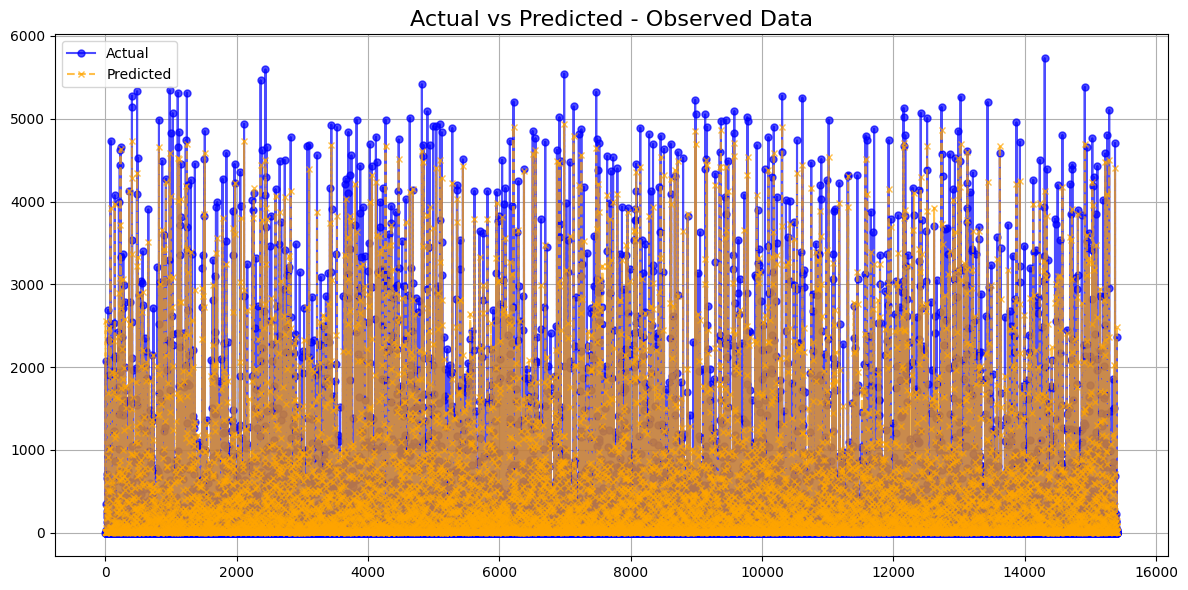

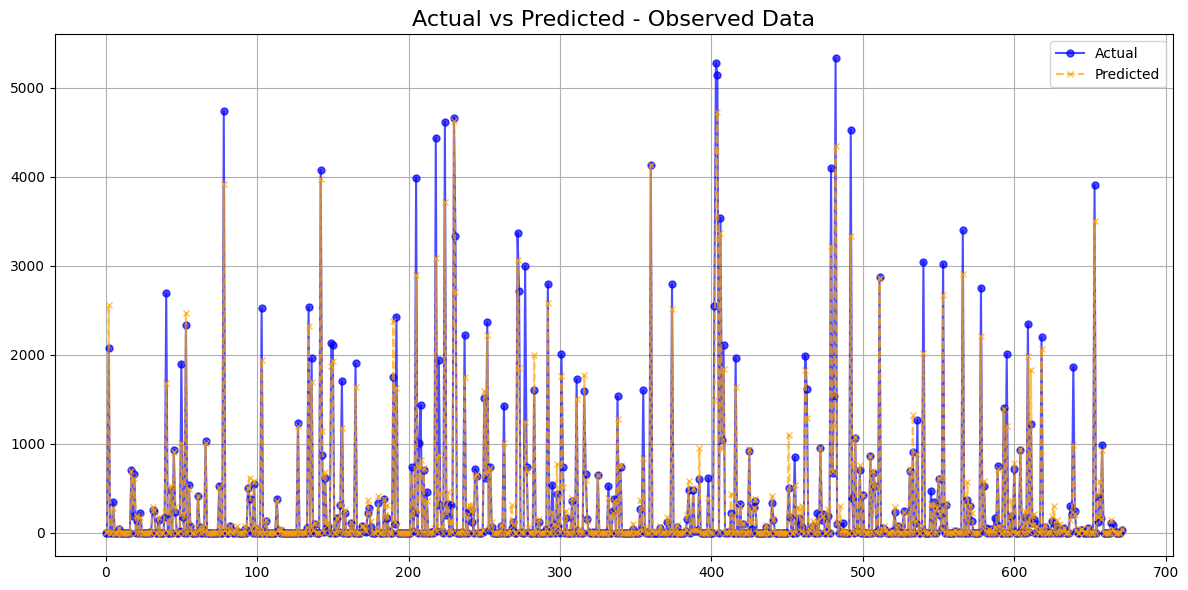

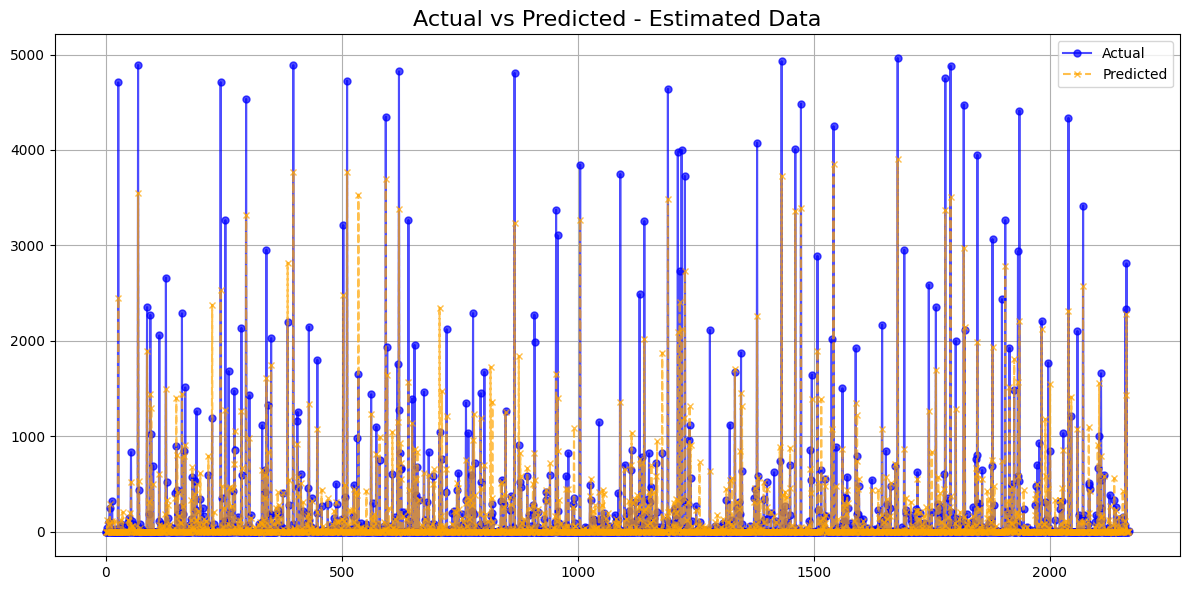

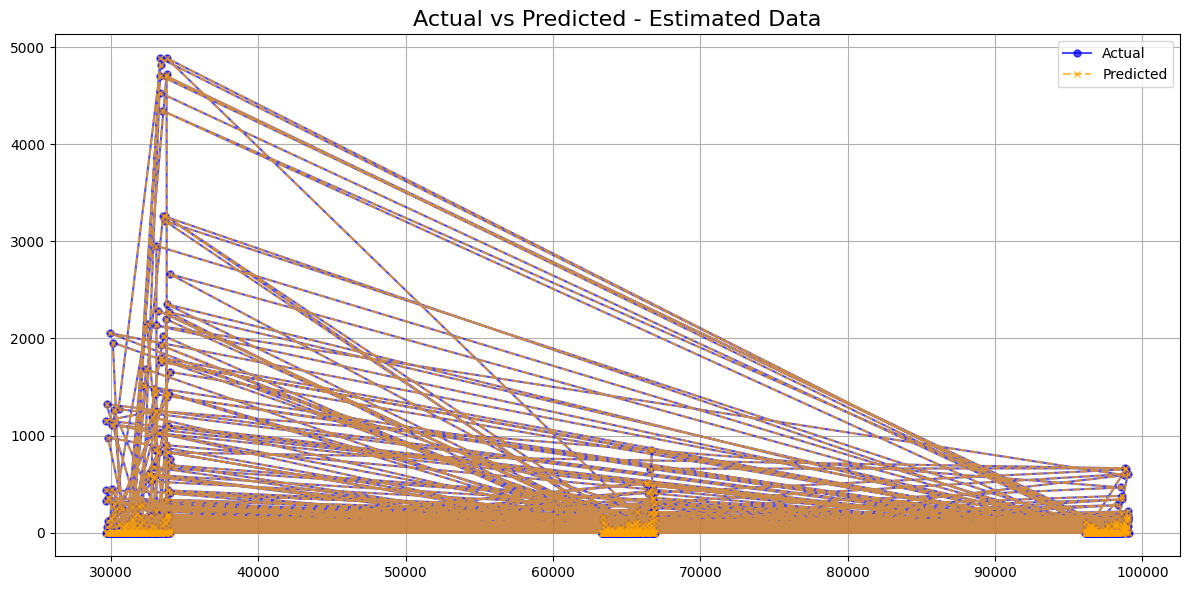

In [ ]:

from matplotlib import pyplot as plt
import pandas as pd
# Set up the plotting area
plt.figure(figsize=(12, 6))

# Line plot of Actual values
plt.plot(y_val_obs_combined.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')

# Line plot of Predicted values
plt.plot(pd.Series(y_pred_val_obs_combined, index=y_val_obs_combined.index).reset_index(drop=True), label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')

# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

# Line plot of Actual values
plt.plot(y_val_obs_combined[0:24*7*4].reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')

# Line plot of Predicted values
plt.plot(pd.Series(y_pred_val_obs_combined[0:24*7*4], index=y_val_obs_combined[0:24*7*4].index).reset_index(drop=True), label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')

# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Estimated data

plt.figure(figsize=(12, 6))

# Line plot of Actual values
plt.plot(y_val_est_combined.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')

# Line plot of Predicted values
plt.plot(y_pred_val_est_combined, label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')

# Titles and labels
plt.title('Actual vs Predicted - Estimated Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

# Line plot of Actual values
plt.plot(y_val_est_combined[0:24*7*4], label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')

# Line plot of Predicted values
plt.plot(y_val_est_combined[0:24*7*4], label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')

# Titles and labels
plt.title('Actual vs Predicted - Estimated Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In [ ]:
from src.models.saving import save_predictions


save_predictions(y_pred_test_est_combined, 'stacking with possible data leakage')


   id  prediction
0   0    0.525822
1   1    0.544869
2   2    0.523621
3   3    6.541533
4   4  192.357254


In [ ]:
automl = AutoML(
    mode="Complete",
    total_time_limit=24 * 60 * 60,
    eval_metric="mae",
    golden_features=True,
    feature_selection=True,
    stack_models=True,
    algorithms=["Linear", "Random Forest", "LightGBM", "Xgboost", "CatBoost"],
    train_ensemble=True,
    validation_strategy={"validation_type": "split", "train_ratio": 0.75, "shuffle": False},
)